In [22]:
import umap
import random, os
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

from aum import AUMCalculator
from aum import DatasetWithIndex

from copy import deepcopy
from random import sample


import sys
sys.path.insert(0, "../")



In [ ]:
from data_iq.dataiq_class import *
from src.utils.utils import *
from src.models.neuralnets import *
from src.utils.data_loader import *

In [23]:
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])

# Show the by chance failure use of averaged uncertainty estimation methods. i.e. specfic example of failure

### Train base model

In [24]:
dataset = 'covid' # specifc example

train_loader, train_data, X_train, y_train, X_test, y_test, X_train_pd, y_train_pd, X_test_pd, y_test_pd, nlabels, corr_vals, column_ids, df = load_dataset(dataset=dataset, seed=32)

n_feats = X_train.shape[1]
nlabels = len(np.unique(y_train))

LEARNING_RATE = 0.001
EPOCHS=10
dataiq_list=[]

checkpoint_list = []
losses = []
val_losses = []
ckpt_nets = []

train_loader = DataLoader(dataset=DatasetWithIndex(train_data), batch_size=128, shuffle=True)

net = Net1(input_size=n_feats, nlabels=nlabels)
net.to(device)
criterion = torch.nn.NLLLoss()

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
dataiq = DataIQ_Torch(X=X_train , y=y_train, sparse_labels=True)
dataiq.on_epoch_end(net, device=device)
dataiq_list.append(dataiq)

for e in range(1, EPOCHS+1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch, sample_ids in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        sf = nn.LogSoftmax()
        y_pred = net(X_batch)

        _, predicted = torch.max(y_pred.data, 1)

        y_batch=y_batch.to(torch.int64)
        
        loss = criterion(sf(y_pred), y_batch)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += (predicted == y_batch).sum().item()/len(y_batch)

    # log with data-iq
    dataiq.on_epoch_end(net, device=device)
    
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    ckpt_nets.append(deepcopy(net))
    losses.append(epoch_loss/len(train_loader))

checkpoint_list.append(ckpt_nets)
dataiq_list.append(deepcopy(dataiq))

    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 001: | Loss: 0.68438 | Acc: 0.569
Epoch 002: | Loss: 0.67760 | Acc: 0.617
Epoch 003: | Loss: 0.65648 | Acc: 0.652
Epoch 004: | Loss: 0.61877 | Acc: 0.690
Epoch 005: | Loss: 0.59429 | Acc: 0.700
Epoch 006: | Loss: 0.58379 | Acc: 0.712
Epoch 007: | Loss: 0.57957 | Acc: 0.715
Epoch 008: | Loss: 0.57621 | Acc: 0.723
Epoch 009: | Loss: 0.56873 | Acc: 0.728
Epoch 010: | Loss: 0.57525 | Acc: 0.718


## Extract intermediate layers & get UMAP embedding of train and test

In [25]:
mymodel=checkpoint_list[0][9]
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
mymodel.dense3.register_forward_hook(get_activation('dense3'))
output = mymodel(torch.tensor(X_train,device=device))
intermediate_train = activation['dense3'].cpu().numpy()

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
mymodel.dense3.register_forward_hook(get_activation('dense3'))
try:
  output = mymodel(torch.tensor(X_test,device=device))
except:
  output = mymodel(torch.tensor(X_test.to_numpy().astype(np.float32),device=device))
intermediate_test = activation['dense3'].cpu().numpy()


mapper = umap.UMAP().fit(intermediate_train, y=y_train)
embedding_train = mapper.transform(intermediate_train)
embedding_test = mapper.transform(intermediate_test)



## Find Data-IQ subgroups

In [26]:
d_idx=0
aleatoric_train = dataiq_list[d_idx].aleatoric
confidence_train = dataiq_list[d_idx].confidence

percentile_thresh = 50
conf_thresh = 0.5
conf_thresh_low = 0.25
conf_thresh_high = 0.75

hard_train = np.where((confidence_train <= conf_thresh_low) & (aleatoric_train <= np.percentile(aleatoric_train,   percentile_thresh)))[0]
easy_train = np.where((confidence_train >= conf_thresh_high) & (aleatoric_train <= np.percentile(aleatoric_train,   percentile_thresh)))[0]

hard_easy = np.concatenate((hard_train,easy_train))
incons_train = []
for id in range(len(confidence_train)):
  if id not in hard_easy:
    incons_train.append(id)
incons_train= np.array(incons_train)

print('Train :', len(hard_train),  len(incons_train),  len(easy_train))


Train : 394 2065 1670


## Get surrogate targets in UMAP embedded space, i.e. so we can label which samples might be Ambiguous

In [27]:
labels= []

for idx in range(len(y_train)):
  if idx in easy_train:
    labels.append(0)
  if idx in incons_train:
    labels.append(1)
  if idx in hard_train:
    labels.append(2)

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X= embedding_train, y=labels)

surrogate_targets = neigh.predict(embedding_test)

## Train a BNN (i.e. normal uncertainty estimation) - on average

In [28]:
  from uq360.algorithms.variational_bayesian_neural_networks.bnn import BnnClassification as BNN
  config = {
              "ip_dim":X_train.shape[1], 
              "op_dim":2,                            
              "num_nodes":8, 
              "num_layers":5,
              "step_size":3e-2,
              "num_epochs":10,
          }

  bnn = BNN(config)
  bnn.fit(X_train, pd.Series(y_train))

  try:
    ypred = bnn.predict(X_test,mc_samples=50)
  except:
    ypred = bnn.predict(X_test.to_numpy(),mc_samples=50)

Epoch[10/10], neg elbo: 0.870730


# Helper to make predictions with NN

In [29]:

  def nn_pred(X_test):
    net_test = ckpt_nets[9]
    net_test.eval()
    with torch.no_grad():
        X_batch = torch.tensor(X_test)
        X_batch = X_batch.to(device)
        y_train_pred = net_test(X_batch)
        _, predicted = torch.max(y_train_pred.data, 1)
        preds = predicted.cpu().numpy()
    return preds


## Sort scores from most to least certain based on the BNN's estimation of uncertainty

### Assess the "surrogate" AMBIGUOUS group compared to the average (i.e. all together)

In [30]:
  from sklearn.metrics import accuracy_score
  from collections import Counter

  preds = nn_pred(X_test)
  
  interval=10

  sorted_scores = {}
  
  # Get Ambiguous group accuracy scores
  scores = []
  partition = np.where(surrogate_targets==1)[0]
  for i in range(10,100+interval,interval):
    var_preds = ypred[2][partition,1]

    ids = np.where(var_preds<np.percentile(var_preds,i))[0]
    partition1 =partition [ids]
    preds = nn_pred(X_test[partition1,:])
    scores.append(accuracy_score(preds,y_test[partition1]))

  sorted_scores['ambig']=scores

  # Get Average group accuracy scores
  scores = []
  partition = np.where((surrogate_targets==2)|(surrogate_targets==1)|(surrogate_targets==0))[0]
  for i in range(10,100+interval,interval):
    var_preds = ypred[2][partition,1]

    ids = np.where(var_preds<np.percentile(var_preds,i))[0]
    partition1 =partition[ids]
    preds = nn_pred(X_test[partition1,:])
    scores.append(accuracy_score(preds,y_test[partition1]))

  sorted_scores['average']=scores


/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/content/src/models/neuralnets.py:27: UserWar

# Plot

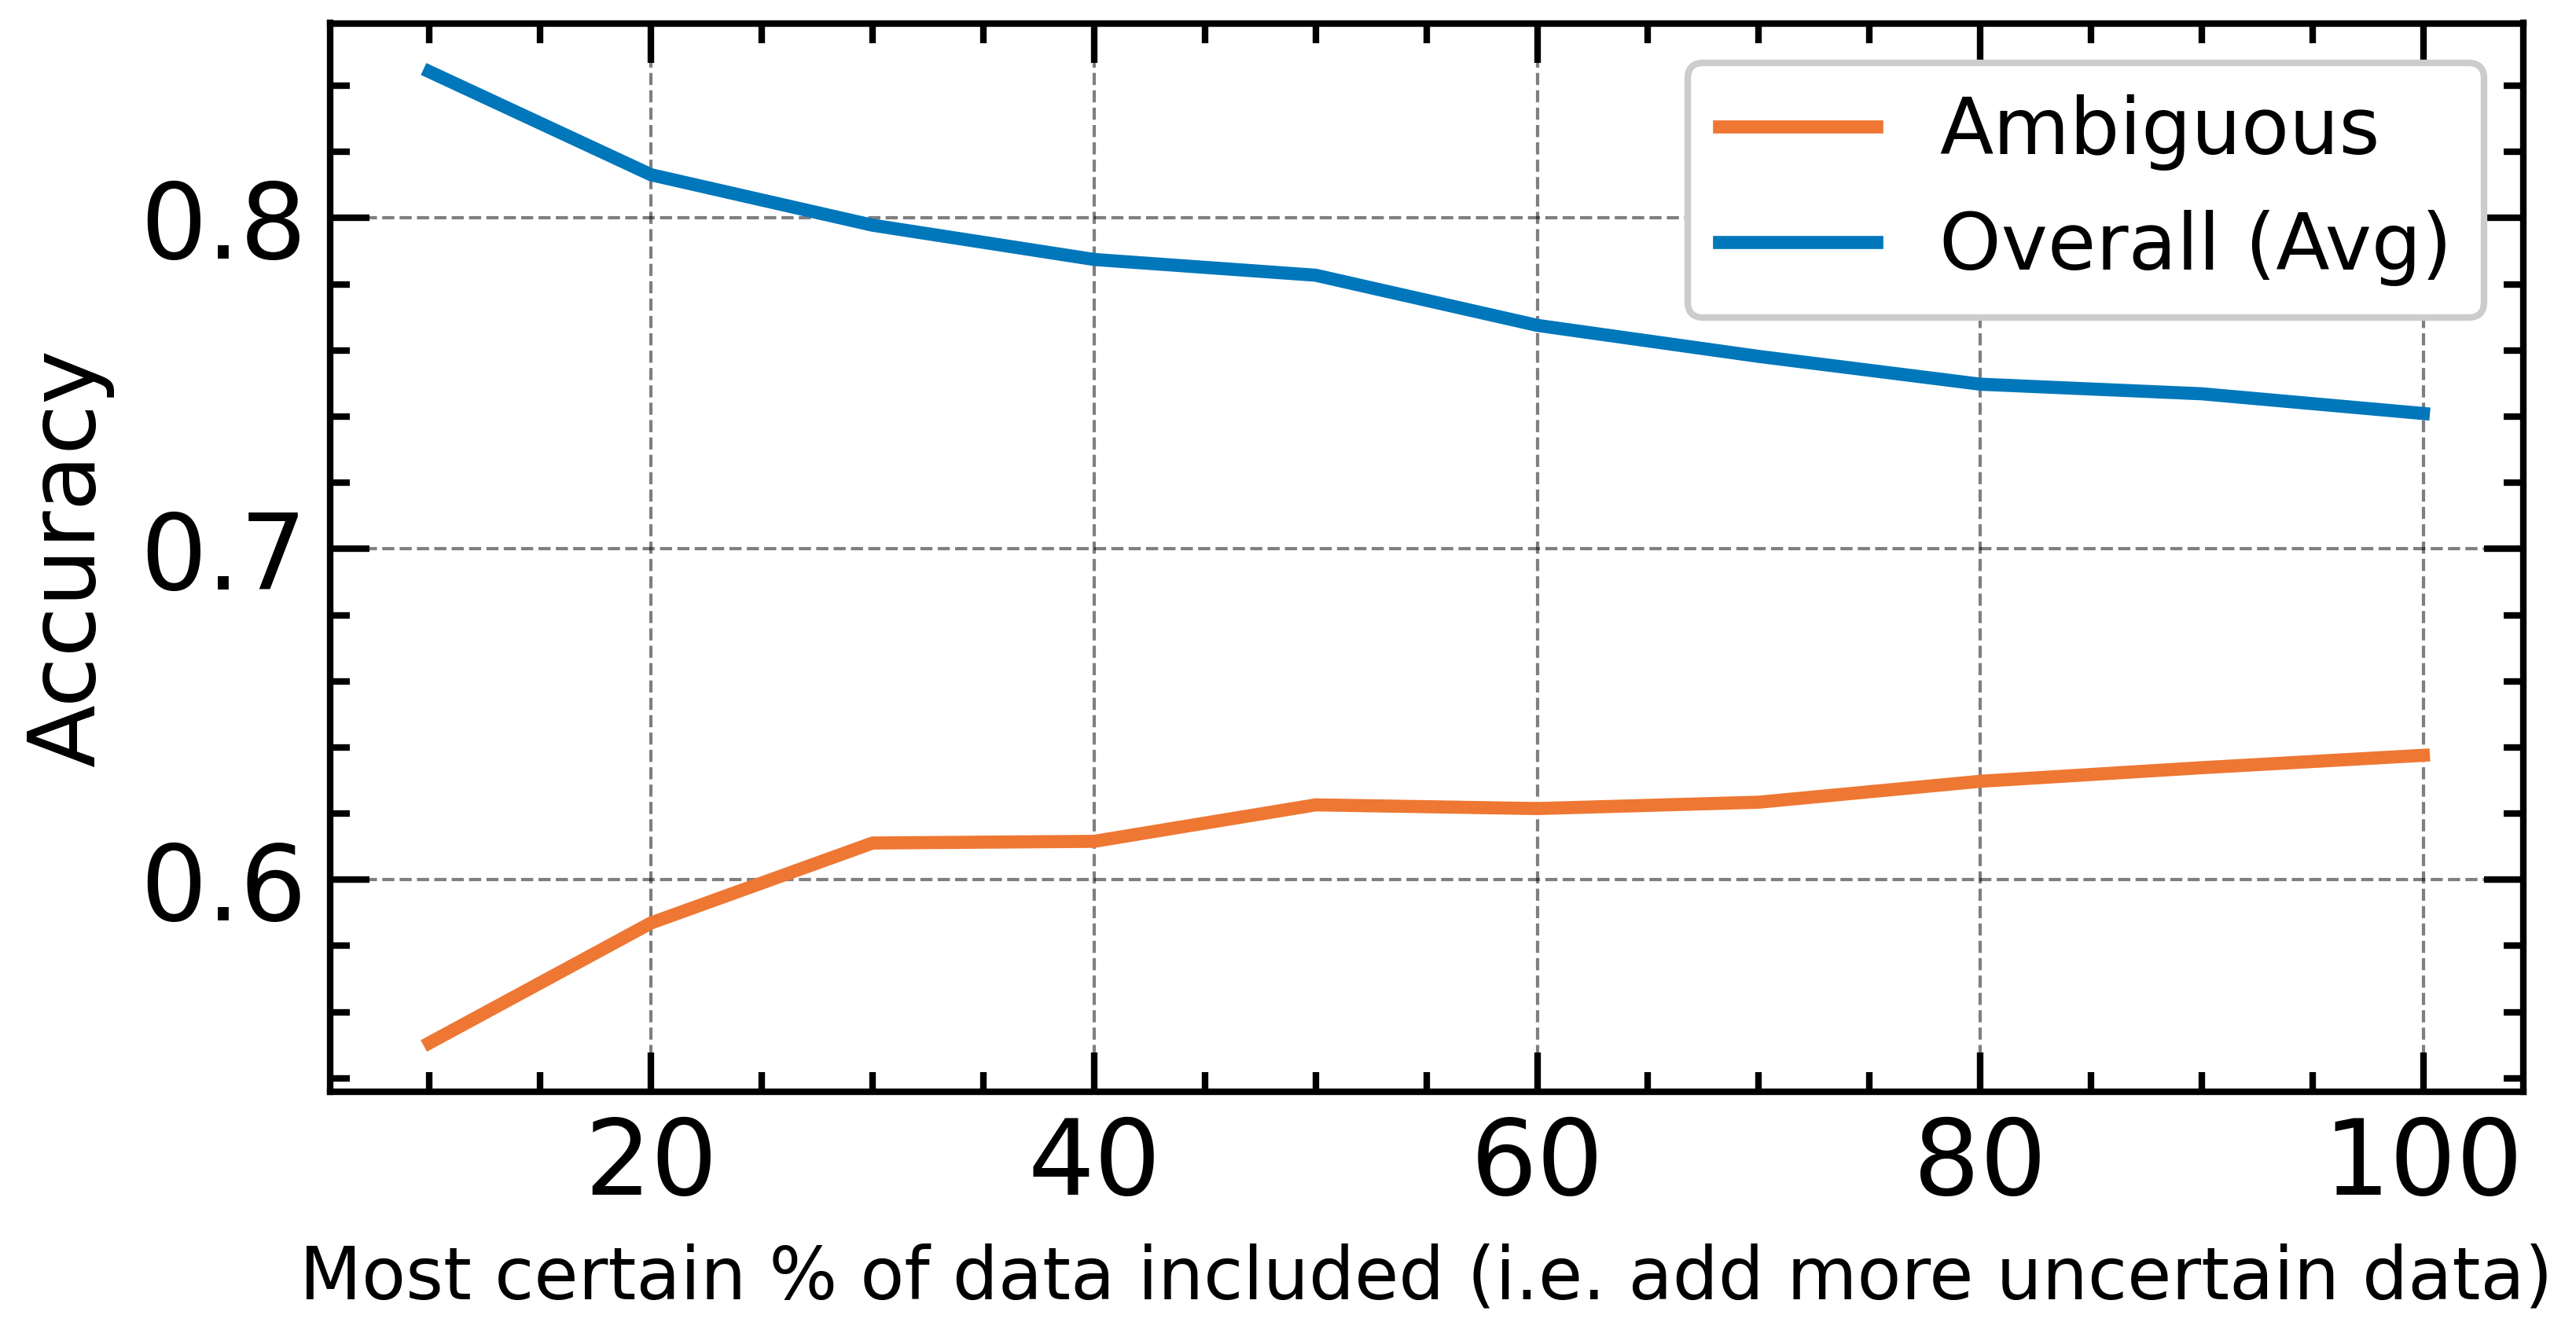

In [31]:
plt.figure(figsize=(6,3))
xvals = range(10,100+interval,interval)
plt.plot(xvals, sorted_scores['ambig'], label='Ambiguous')
plt.plot(xvals, sorted_scores['average'], label='Overall (Avg)')
plt.legend(loc=1, fontsize=12)
plt.xlabel('Most certain % of data included (i.e. add more uncertain data)',fontsize=11)
plt.ylabel('Accuracy',fontsize=14)